```{toctree}
:caption: Deltakit Textbook
:hidden:
:maxdepth: 1
About this textbook <notebooks/about-this-textbook>
Lessons from classical error correction <notebooks/classical-intuition>
Correctable errors <notebooks/correctable-errors>
Bit-flip repetition codes from scratch <notebooks/bit-flip-repetition-codes>
Phase-flip repetition codes from scratch <notebooks/phase-flip-repetition-codes>
Running fast circuit simulations <notebooks/running-faster-circuit-simulations>
Shor's 9-qubit code <notebooks/shor-code>
Decoder library <notebooks/decoder-library>
```

# Deltakit Textbook
Welcome! The Deltakit Textbook aims to be a hands-on introduction to quantum error correction concepts coupled with practical examples for exploring error-correcting codes. Written by the __[Riverlane](https://riverlane.com)__ team and friends.

In [1]:
import numpy as np
import matplotlib.pyplot as plotter; plotter.rcParams['font.family'] = 'Monospace'
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
import holoviews as hv
from holoviews import opts
import warnings; warnings.filterwarnings('ignore')
import panel as pn
from tqdm import tqdm
try:
    import mlx.core as mx  # Apple's MLX library for Apple Silicon
except ImportError:
    raise RuntimeError("MLX not available. Uncomment the raw numbers to make the plot.")

In [2]:
def simulate_classical_rep_codes_with_gpu_mlx(distance, error_probability, n_shots):

    total_logical_errors = 0
    batch_size = min(int(500_000_000 * 1.), n_shots)  # Process 500M at a time on GPU
    
    shots_processed = 0
    while shots_processed < n_shots:
        current_batch = min(batch_size, n_shots - shots_processed)
        
        # Generate random desired messages for this batch in GPU
        desired_messages = mx.random.randint(low = 0, high = 2, shape=(current_batch,))
        
        # Encode: replicate each bit distance times in GPU
        encoded_messages = mx.repeat(desired_messages[:, mx.newaxis], distance, axis=1)

        # Send: simulate bit flip errors
        error_mask = mx.random.uniform(low = 0, high = 1, shape=(current_batch, distance)) <= error_probability
        sent_messages = encoded_messages ^ error_mask
        
        # Receive and interpret: majority voting
        received_messages = mx.sum(sent_messages, axis=1) > (distance // 2)
                
        # Accumulate errors and bring them back to CPU
        total_logical_errors += int(mx.sum(received_messages != desired_messages))
        shots_processed += current_batch
            
    return total_logical_errors / (n_shots * 1.)

In [3]:
def get_all_code_distance_error_probabilities(code_distances, p_errors, n_shots = int(1e5)):

    all_code_distance_error_probabilities = []
    for distance in code_distances:
        this_code_distance_error_probabilities = []
        for p_error in tqdm(p_errors):
            this_code_distance_error_probabilities.append(
                            simulate_classical_rep_codes_with_gpu_mlx(
                            distance, p_error, n_shots
                            ))
        all_code_distance_error_probabilities.append(this_code_distance_error_probabilities)

    return all_code_distance_error_probabilities

In [4]:
# code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
# p_errors = np.sort(np.append(np.logspace(start=-4, stop=0, num=20), 0.5))
# n_shots = int(20e9)
 
# all_logical_errors = get_all_code_distance_error_probabilities(
#                                         code_distances = code_distances, 
#                                         p_errors = p_errors, 
#                                         n_shots = n_shots
#                                         )

In [5]:
code_distances = np.arange(start=1, stop=13+1, step=2)  # [1, 3, 5, 7, 9, 11, 13]
p_errors = np.sort(np.append(np.logspace(start=-4, stop=0, num=20), 0.5))
n_shots = int(20e9)

all_logical_errors = np.array([
[9.98658e-05,0.0001622452,0.00026362745,0.00042824465,0.0006949711,0.0011293672,0.001832927,0.0029756828,0.00483298795,0.0078474256,0.01274254065,0.020692267,0.0335968143,0.05455613395,0.08858471805,0.14384386975,0.23356963985,0.3792706048,0.5000000000,0.61584862375,1.0],
 [3.16e-08,7.815e-08,2.086e-07,5.543e-07,1.44495e-06,3.80925e-06,1.009335e-05,2.653395e-05,6.980555e-05,0.0001838169,0.000483003,0.00126697785,0.0033109893,0.0086042983,0.02215198835,0.05612229765,0.138184406,0.3224239051,0.5000000000,0.67066496785,1.0],
 [5e-11,5e-11,2.5e-10,7e-10,3e-09,1.27e-08,6.21e-08,2.633e-07,1.1164e-06,4.7742e-06,2.03122e-05,8.584965e-05,0.0003606729,0.00149394695,0.0060614667,0.0237129361,0.0869526594,0.28227525345,0.5000000000,0.70956449185,1.0],
 [0.0,0.0,0.0,0.0,5e-11,0.0,3.5e-10,3.55e-09,1.83e-08,1.321e-07,8.9615e-07,6.10215e-06,4.104715e-05,0.00027122285,0.0017290775,0.0104069317,0.0563852906,0.2507697618,0.5000000000,0.7402483224,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,5e-11,0.0,2e-10,4.25e-09,4.095e-08,4.4495e-07,4.8327e-06,5.058045e-05,0.00050636495,0.0046716422,0.03723282475,0.2248085391,0.5000000000,0.7656526207,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1e-10,2.2e-09,3.32e-08,5.7705e-07,9.57245e-06,0.00015069965,0.00212901415,0.02488740735,0.2028033932,0.5000000000,0.7872835466,1.0],
 [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2e-10,3.4e-09,7.05e-08,1.8456e-06,4.537795e-05,0.00098095945,0.0167868647,0.1838117115,0.5000000000,0.80605446975,1.0]
])
# [9.07s/it]
# [17.15s/it]
# [23.59s/it]
# [37.21s/it]
# [48.43s/it]
# [56.13s/it]
# [64.06s/it]

In [6]:
def make_inset_hook(xlim, ylim, *, size="35%", loc="lower right",
                    bbox=(0.05, 0.05, 1, 1), borderpad=0.8, mark=False,
                    inset_xticks=None, inset_yticks=None, 
                    inset_xtick_font=None, inset_ytick_font=None,
                   pos):
    def _hook(plot, element):
        ax = plot.handles["axis"] # main Matplotlib axes

        if pos is not None:
            x, y, w, h = pos
            iax = ax.inset_axes([x, y, w, h], transform=ax.transAxes, zorder=5)
        else:
            iax = inset_axes(ax, width=size, height=size, loc=loc, borderpad=borderpad)

        # Draw the current element's data into the inset
        x = element.dimension_values(0)
        y = element.dimension_values(1)
        iax.loglog(x, y, marker = 'o', markersize=10, alpha=0.8)
        iax.loglog(x, x, color='black', linewidth = 1, alpha=0.8)
        iax.grid(True, which="both", alpha=0.3)

        # de-emphasize inset axes
        for spine in iax.spines.values():
            spine.set_alpha(0.6)
            spine.set_linewidth(1.0)
        for lbl in iax.get_xticklabels() + iax.get_yticklabels():
            lbl.set_alpha(0.4)
        for tl in iax.xaxis.get_ticklines() + iax.yaxis.get_ticklines():
            tl.set_alpha(0.4)
            
        if inset_xticks:
            xs   = [t for t, _ in inset_xticks]
            labs = [l for _, l in inset_xticks]
            iax.xaxis.set_major_locator(FixedLocator(xs))
            iax.xaxis.set_major_formatter(FixedFormatter(labs))
            iax.xaxis.set_minor_locator(NullLocator())
        if inset_yticks:
            ys   = [t for t, _ in inset_yticks]
            labs = [l for _, l in inset_yticks]
            iax.yaxis.set_major_locator(FixedLocator(ys))
            iax.yaxis.set_major_formatter(FixedFormatter(labs))
            iax.yaxis.set_minor_locator(NullLocator())
        iax.set_xlim(*xlim); iax.set_ylim(*ylim)
        if inset_xtick_font:
            if "size" in inset_xtick_font:
                iax.tick_params(axis='x', labelsize=inset_xtick_font["size"])
            for lbl in iax.get_xticklabels():
                if "family" in inset_xtick_font: lbl.set_fontfamily(inset_xtick_font["family"])
                if "weight" in inset_xtick_font: lbl.set_fontweight(inset_xtick_font["weight"])
                if "style"  in inset_xtick_font: lbl.set_fontstyle(inset_xtick_font["style"])
                if "color"  in inset_xtick_font: lbl.set_color(inset_xtick_font["color"])
                if "rotation" in inset_xtick_font: lbl.set_rotation(inset_xtick_font["rotation"])
        if inset_ytick_font:
            if "size" in inset_ytick_font:
                iax.tick_params(axis='y', labelsize=inset_ytick_font["size"])
            for lbl in iax.get_xticklabels():
                if "family" in inset_ytick_font: lbl.set_fontfamily(inset_ytick_font["family"])
                if "weight" in inset_ytick_font: lbl.set_fontweight(inset_ytick_font["weight"])
                if "style"  in inset_ytick_font: lbl.set_fontstyle(inset_ytick_font["style"])
                if "color"  in inset_ytick_font: lbl.set_color(inset_ytick_font["color"])
                if "rotation" in inset_ytick_font: lbl.set_rotation(inset_ytick_font["rotation"])
        rect = Rectangle(
            (xlim[0], ylim[0]),
            xlim[1] - xlim[0], ylim[1] - ylim[0],
            linewidth=1.0,
            edgecolor="black",
            facecolor=(0, 0, 0, 0),
            alpha=1.0,                 
            fill=False,
            zorder=5
        )
        ax.add_patch(rect)
        
        if mark:
            # draw connectors showing the zoomed region
            mark_inset(ax, iax, loc1=2, loc2=4, fc="none", ec="0.3", lw=0.3, color='black',ls='--')
    return _hook

In [7]:
inset_xticks = [
    (1e-1,  r"$0.1$"),
    (5e-1,  r"$0.5$"),
    (1e0,  r"$1$"),
]
inset_yticks = [
    (1e-1,  r"$0.1$"),
    (5e-1,  r"$0.5$"),
    (1e0,  r"$1$"),
]
inset_font   = {"size": 8, "family": "Monospace", "weight": "regular", "color": "#333"}

def error_probabilities_for_code_distance(code_distance):
    error_probabilities = all_logical_errors[code_distances.tolist().index(code_distance)]
    return hv.Curve((
        p_errors,
        error_probabilities 
    )).opts(
        xlabel="Per-bit error probability",
        ylabel="Message error probability",
        logx=True,
        logy=True,
        marker='o',
        ylim=(1e-9, 1.1),
        xlim=(1e-9, 1.1),
        backend_opts={"axes.patch.edgecolor": 'black', "axes.patch.linewidth": 1},
        fig_size = 135,
        title = '',
        show_grid=True,
        hooks=[make_inset_hook(                      
            xlim=(1e-1, 1e0),
            ylim=(1e-1, 1e0),
            size="36%", loc="upper left", 
            mark=True, 
            inset_xticks = inset_xticks, inset_yticks = inset_yticks, 
            inset_xtick_font = inset_font, inset_ytick_font = inset_font,
            pos=(0.08, 0.60, 0.40, 0.33),
        )]
    ) * hv.Curve((
        np.linspace(start = 1e-9, stop = 1.1, num = 30),
        np.linspace(start = 1e-9, stop = 1.1, num = 30)
    )).opts(
        opts.Curve(color='black', linewidth=1),
    ) * hv.Text(24e-8, 60e-8, 'y = x (no error correction)', rotation = 45, fontsize = 8)

hv.extension('matplotlib', logo = False)
hv.output(widget_location='bottom')
plot_and_slider = hv.HoloMap(
    {
        code_distance: error_probabilities_for_code_distance(code_distance) for code_distance in code_distances
    },
    kdims=["Repetition Count (Code Distance)"],
)

```{raw} html
<style>
.explanation-text {
    font-family: Monospace;
    font-size: 12px;
    line-height: 1.3;
    color: #333;
    padding-right: 20px;
    padding-top: 40px;
}
</style>
```

```{raw} html
<div style="display: flex; align-items: start; gap: 30px;">
    <div class="explanation-text" style="flex: 0 0 35%;">
        <p>Imagine a sender transmitting bits (0 or 1) to a receiver over a noisy channel where some bits get flipped. To correct errors, the sender repeats the message several times, and the receiver uses a majority vote to determine the original bit -- a simple error-correcting method called a repetition code. The interactive plot shows how increasing the repetition count sharply reduces misinterpretation when the per-bit error probability is low. Use the slider below the plot to change the repetition count and see this effect!</p>
        <p>Plot generated using 20 billion shots per point on an Apple M2 Max processor.</p>
    </div>
    <div style="flex: 1;">
```

:HoloMap   [Repetition Count (Code Distance)]
   :Overlay
      .Curve.I  :Curve   [x]   (y)
      .Curve.II :Curve   [x]   (y)
      .Text.I   :Text   [x,y]
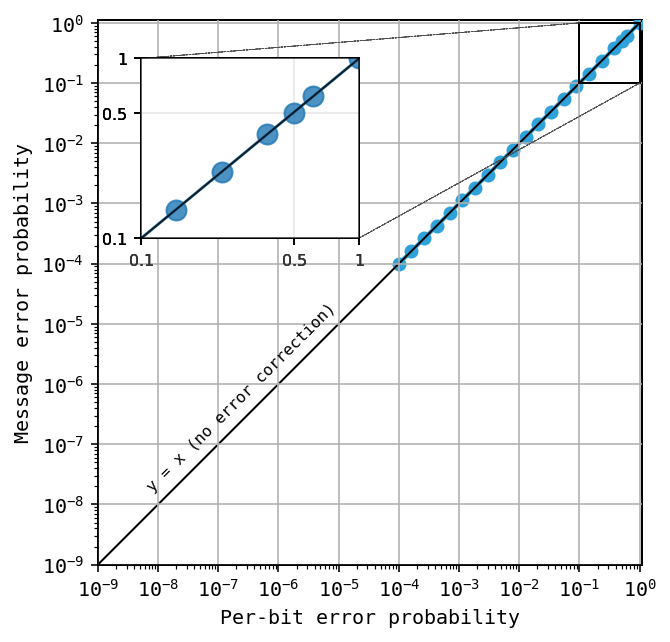
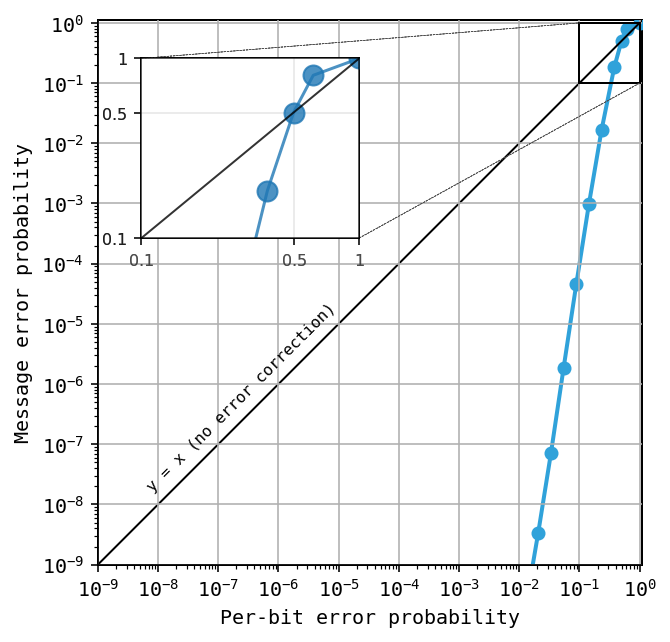
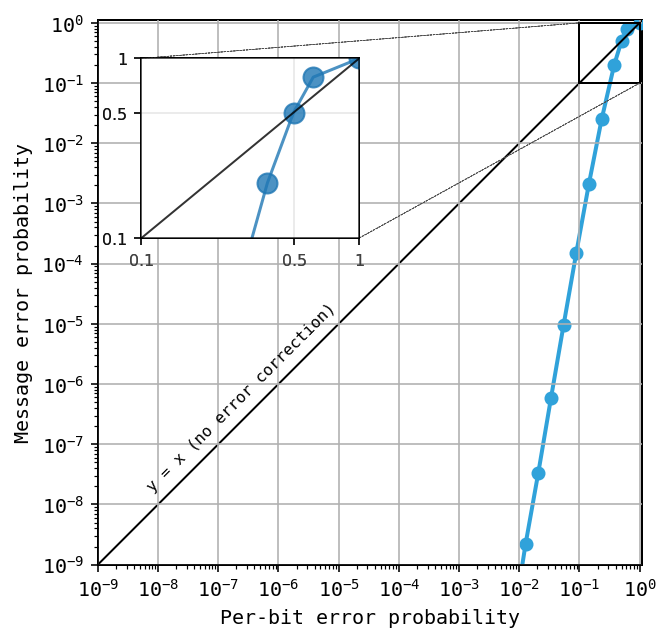
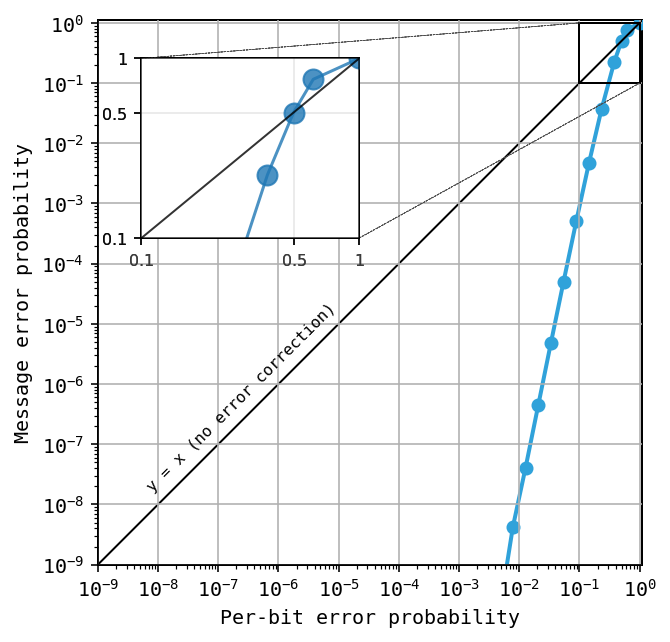
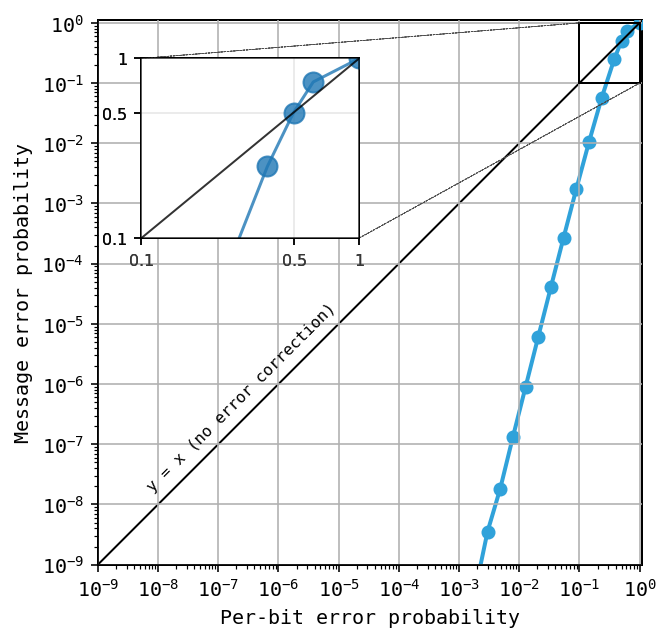
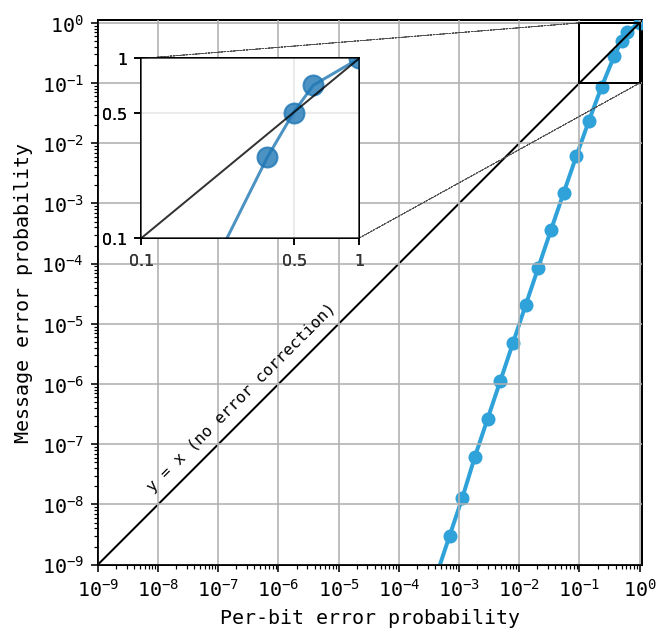
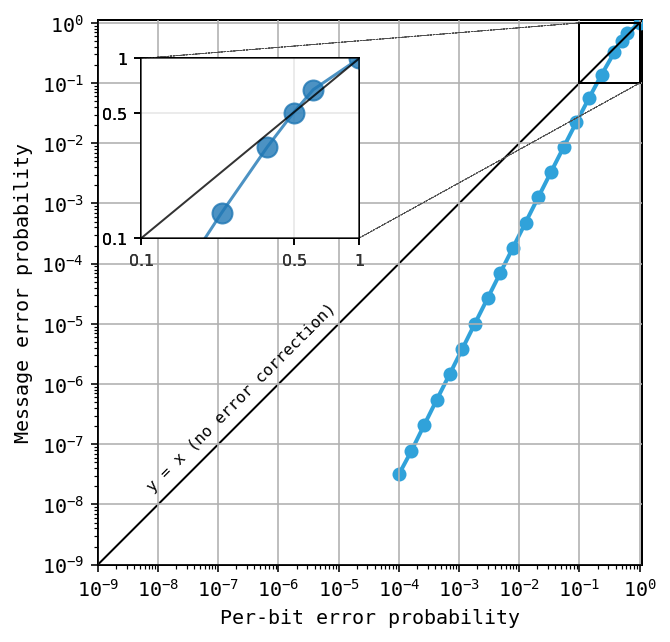
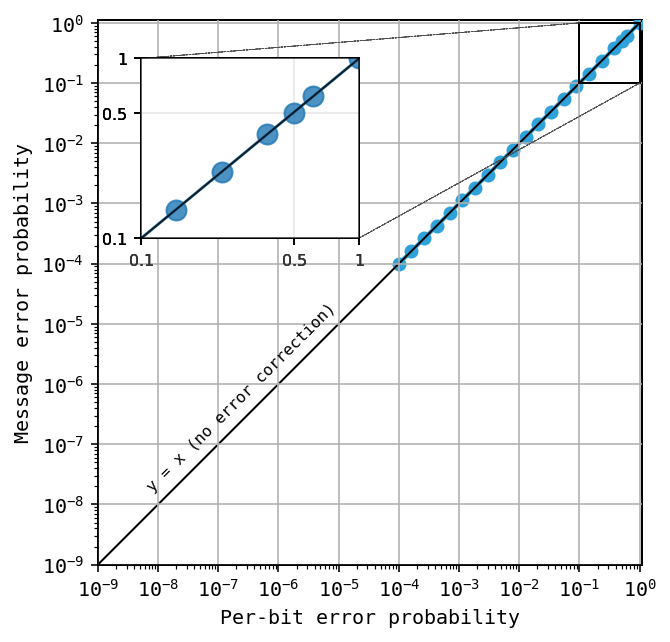

In [8]:
plot_and_slider

```{raw} html
    </div>
</div>
```

## Contents

### __About this textbook__
<ul>
  <li><a href="notebooks/about-this-textbook.html">About this textbook</a></li>
</ul>

### __Developing intuition for quantum error correction__
<ul>
  <li>Motivation for quantum error correction</li>
  <li><a href="notebooks/classical-intuition.html">Lessons from classical error correction</a></li>
  <li>Majority vote vs parity checks</li>
</ul>

### __From classical to quantum repetition codes__
<ul>
  <li><a href="notebooks/correctable-errors.html">Correctable errors</a></li>
  <li><a href="notebooks/bit-flip-repetition-codes.html">Building the bit-flip quantum repetition code from scratch</a></li>
  <li><a href="notebooks/phase-flip-repetition-codes.html">Retooling the bit-flip quantum repetition code to handle phase errors</a></li>
  <li><a href="notebooks/running-faster-circuit-simulations.html">Running faster circuit simulations</a></li>
  <li><a href="notebooks/shor-code.html">Combining bit-flip and phase-flip repetition codes: Shor's 9-qubit code</a></li>
</ul>

### __From repetition codes to surface codes__
<ul>
  <li>Introduction to surface codes</li>
    <li>Layout of unrotated surface code with stabilizers</li>
    <li>Syndrome extraction cycle with noise and logical operators</li>
    <li>Overview of the QEC cycle and introduction to Stim</li>
</ul>

### __Decoding surface codes__
<ul>
  <li>Introduction to minimum weight perfect matching</li>
  <li>Threshold theorem</li>
  <li>Simulating surface code in stim</li>
</ul>

### __Decoder library__
<ul>
  <li><a href="notebooks/decoder-library.html">Decoder library</a></li>
</ul>